In [28]:
%matplotlib inline
import re as re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fa2 import ForceAtlas2

df_names = pd.read_csv("./names_lotr_underscored.csv")

In [8]:
df_names

,Names
0,Anborn
1,Angbor
2,Aragorn_II_Elessar
3,Arod
4,Arwen
5,Asfaloth
6,Angelica_Baggins
7,Dora_Baggins
8,Frodo_Baggins
9,Willie_Banks


In [9]:
import json
import urllib2
import io as io
import pandas as pd
import networkx as nx

def get_wikipedia_page(page_name):
    
    """
    input : 
    - the name of a wikipedia page
    output : 
    - the json containing the content of the wikipedia page
    """
    baseUrl = "http://lotr.wikia.com/api.php?"
    action =  "action=query"
    title = "titles="+page_name
    content = "prop=revisions&rvprop=content"
    dataFormat = "format=json"
    query = "%s%s&%s&%s&%s" % (baseUrl,action,title,content,dataFormat)

    rep = urllib2.urlopen(query)
    rep2 = rep.read()
    jsonRep = json.loads(rep2)
    return jsonRep

def getHouseForCharacters(jsonRep):
    base = 'https://api.got.show/api/characters/'
    response = urlopen(base)
    html = response.read()
    chars = json.loads(html)
    for c in chars:
        name = c['name'].replace(' ', '_')
        if name in characters:
            if 'house' in c:
                characters[name]['house'] = c['house']    
    return characters

def save_all_wiki_page(dataset, folder_name):
    """
    input : 
    - congress_data_frame = the data frame containing the information about one congress
    - folder_name = the folder name where to put the extracted wikipedia pages from the list of names in the dataframe
    output :
    - boolean : True. This function create .txt files in the folder named with folder_name
    
    """
    for name in dataset['Names']:
        page = get_wikipedia_page(name)
        filename = folder_name + "/" + name + '.txt'
        f = io.open(filename,'w',encoding="utf-8")
        f.write(unicode(json.dumps(page, ensure_ascii=False)))
        f.close
    return ('The .txt files for each wikipedia page have been created')

def get_hyperlinks_in_wikipage(dataset, path_folder):
    """
    input :
    - dataset : the dataframe object containing information about one congress
    - path_folder : the path to the folder where the wikipedia pages in .txt are present
    output :
    - a dict object containing all the hyperlinks contained in each wikipedia pages.
    Keys of the dict are the congressman names and the Values are the hyperlinks contained in the page
    """
    dict_link = {}
    for i in range(len(dataset.Names.sort_values())):
        character = dataset.Names.sort_values().iloc[i]
        filename = path_folder + '/' + character + '.txt'
        f = io.open(filename,'r',encoding="utf-8").read()
        #regex = r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]'
        regex = ".*?\[\[(.*?)[\]\|]"
        links = re.findall(regex,f)
        dict_link[character]=links
    return dict_link

def get_list_of_name_for_one_congress(dataset):
    """
    input : 
    - dataset : the dataset containing information about one congress
    output :
    - a array containing the list of the congressman name present in the congress. The "_" are removed
    and replaced by space.
    """
    list_of_name = []
    for l in dataset['Names'].sort_values():
        m = l.replace("_", " ")
        list_of_name.append(m)
        #print(m)
    return list_of_name

def find_links(list_of_links, list_of_name_for_congress):
    """
    input : 
    - list_of_links : the list of links present in one wikipedia apge
    - list_of_name_for_congress : the list of name of congressman present in the congress
    output :
    - a list containing the list of name of the congressmen who appear in the wikipedia page and in the congress
    """
    match = []
    for l in list_of_links:
        if l.encode('utf-8') in list_of_name_for_congress:
            if l.encode('utf-8') not in match:
                match.append(l.encode('utf-8'))
    return match

def create_relation(dataset, path_folder):
    """
    input : 
    - dataset : the dataset containing information about one congress
    - path_folder : the path to the folder where the wikipedia pages in .txt are present
    output :
    - a dict object with congressman name as Keys and 
    the name of the others congressman present in his wikipedia page as Values
    for each congressman present in the congress represented by dataset
    """
    list_of_name_congress = get_list_of_name_for_one_congress(dataset)
    dict_links = get_hyperlinks_in_wikipage(dataset, path_folder)
    relationship = {}
    for congressman, list_of_links in dict_links.items():
        new_congressman = congressman.replace("_"," ")
        #relationship[new_congressman.encode('utf-8')] = find_links(list_of_links,list_of_name_congress)
        relationship[new_congressman] = find_links(list_of_links,list_of_name_congress)
    return relationship
    
def create_edges_for_one_congressman(congressman, list_of_relations):
    """
    input : 
    - congressman : the name of one congressman
    - list_of_relations: a list of name
    output :
    - a list containing link the congressman and every name in the list of relations
    """
    edges = []
    for l in list_of_relations:
        edges.append([congressman, l])
    return edges
    
def create_edges(dict_relation):
    """
    input :
    - dict_relation : a dict object with congressman name as Keys and 
    the name of the others congressman present in his wikipedia page as Values
    output :
    - a array containing a list of edges which are a link between 2 congressman as contained in the input dict.
    """
    list_of_edges = []
    for congressman, relations in dict_relation.items():
        for edge in create_edges_for_one_congressman(congressman, relations):
            list_of_edges.append(edge)
    return list_of_edges

In [10]:
save_all_wiki_page(df_names,"./characters")

'The .txt files for each wikipedia page have been created'

In [11]:
relation_lotr = create_relation(df_names, './characters/')

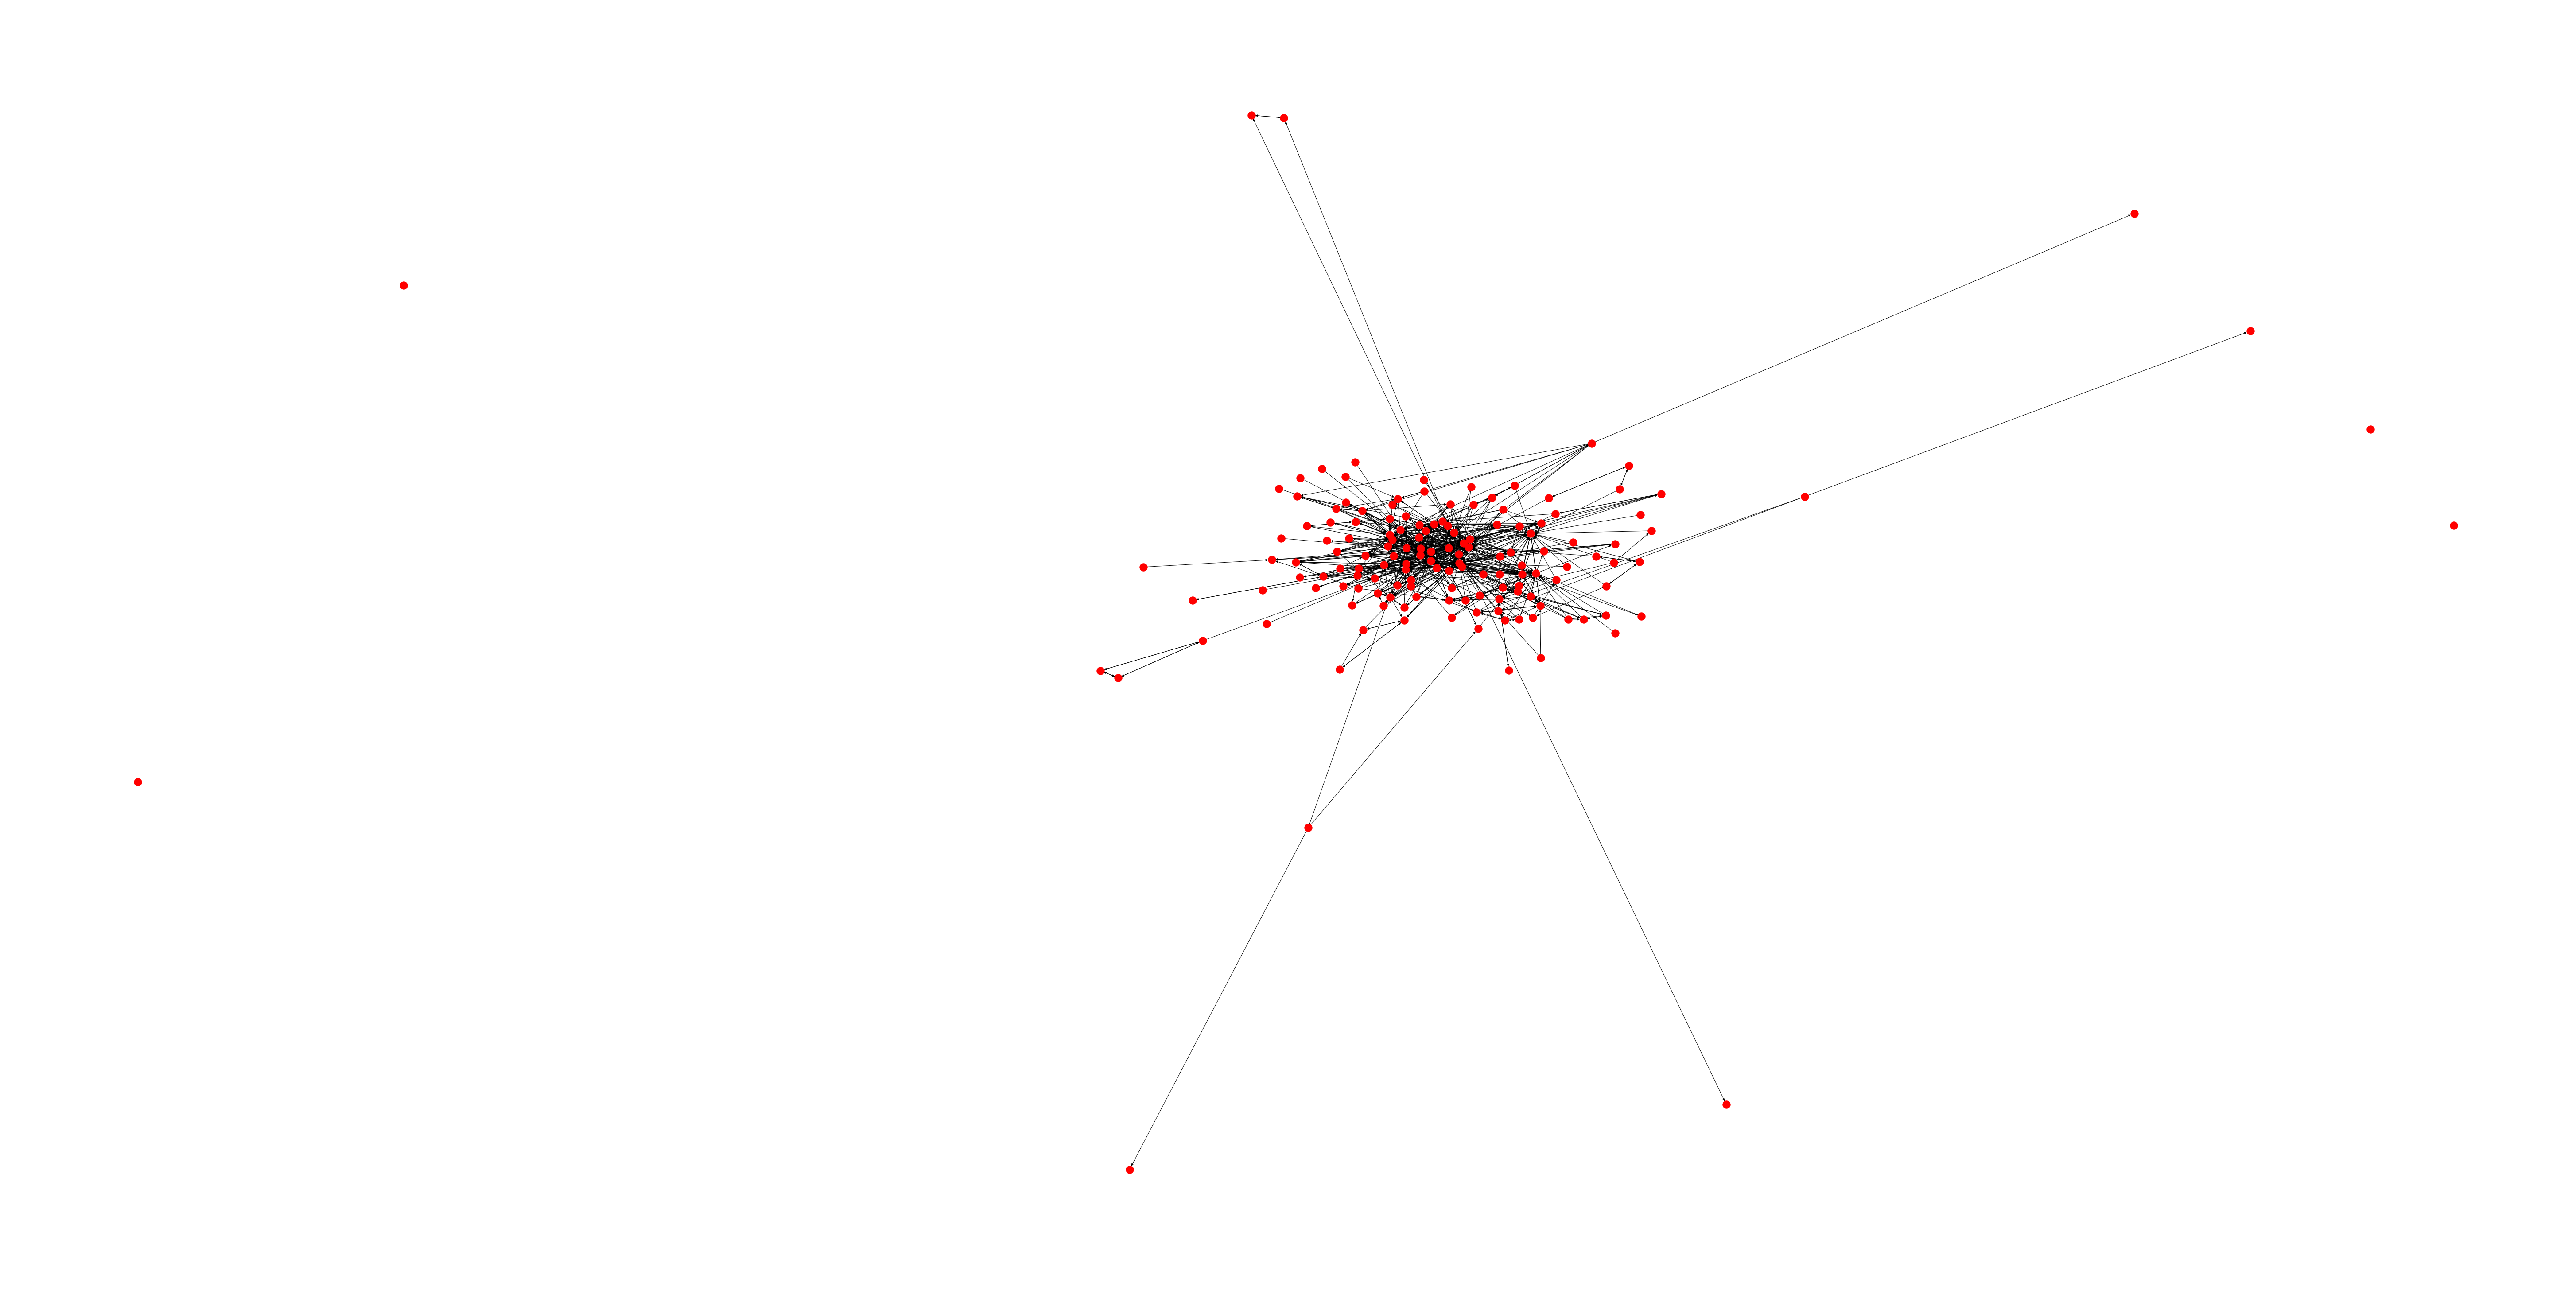

In [12]:
G = nx.DiGraph()
list_of_nodes = relation_lotr.keys()
G.add_nodes_from(list_of_nodes)
list_of_edges = create_edges(relation_lotr)
G.add_edges_from(list_of_edges)
plt.figure(1,figsize=(80,40))
nx.draw(G)
plt.draw()

In [13]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 152
Number of edges: 793
Average in degree:   5.2171
Average out degree:   5.2171


In [69]:
ordabok = dict(G.degree)

d_view = [ (v,k) for k,v in ordabok.iteritems() ]
d_view.sort(reverse=True) # natively sort tuples by first element
#for v,k in d_view:
#    print "%s: %d" % (k,v)

#print(len(d_view))

d_view[0][1]
print('The person with the highest number of degree is {}, with degree value {}.'.format(d_view[0][1],d_view[0][0]))
print('The persons with the lowest number of degree are {}, {}, {} and {}, with degree value {}.'.format(d_view[151][1],d_view[150][1],d_view[149][1],d_view[148][1],d_view[150][0]))

The person with the highest number of degree is Frodo Baggins, with degree value 81.
The persons with the lowest number of degree are Beechbone, Fastred (Pelennor Fields), Herefara and Targon, with degree value 0.


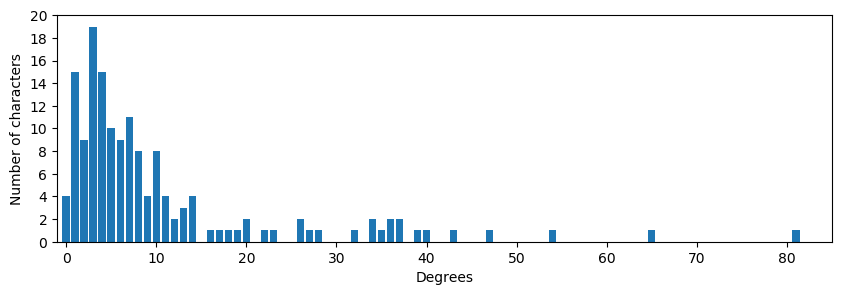

In [79]:
#package which allows division to always result in a decimal number.
from __future__ import division
from collections import Counter

#Average degree like in example above:
G_vals = dict(G.degree()).values()
#Order them likewise
v = {"bin_edge" : [],"val_counts" : []}
for num, val in Counter(G_vals).items():
    v["bin_edge"].append(num)
    v["val_counts"].append(val)

#Finally a nice bar plot.
plt.figure(figsize=(10,3),dpi=100)
plt.bar(v["bin_edge"],v["val_counts"])
plt.yticks([0,2,4,6,8,10,12,14,16,18,20])
plt.xlim([-1,85])
plt.xlabel('Degrees')
plt.ylabel('Number of characters')
plt.show()

In [73]:
from collections import Counter

InDeg = [val for (node, val) in G.in_degree()]
OutDeg = [val for (node, val) in G.out_degree()]


#Degree distributions:
IN_deg_dist = {"bin_edge" : [],"val_counts" : []}
OUT_deg_dist = {"bin_edge" : [],"val_counts" : []}

for num, val in Counter(InDeg).items():
    IN_deg_dist["bin_edge"].append(num)
    IN_deg_dist["val_counts"].append(val)
for num, val in Counter(OutDeg).items():
    OUT_deg_dist["bin_edge"].append(num)
    OUT_deg_dist["val_counts"].append(val)

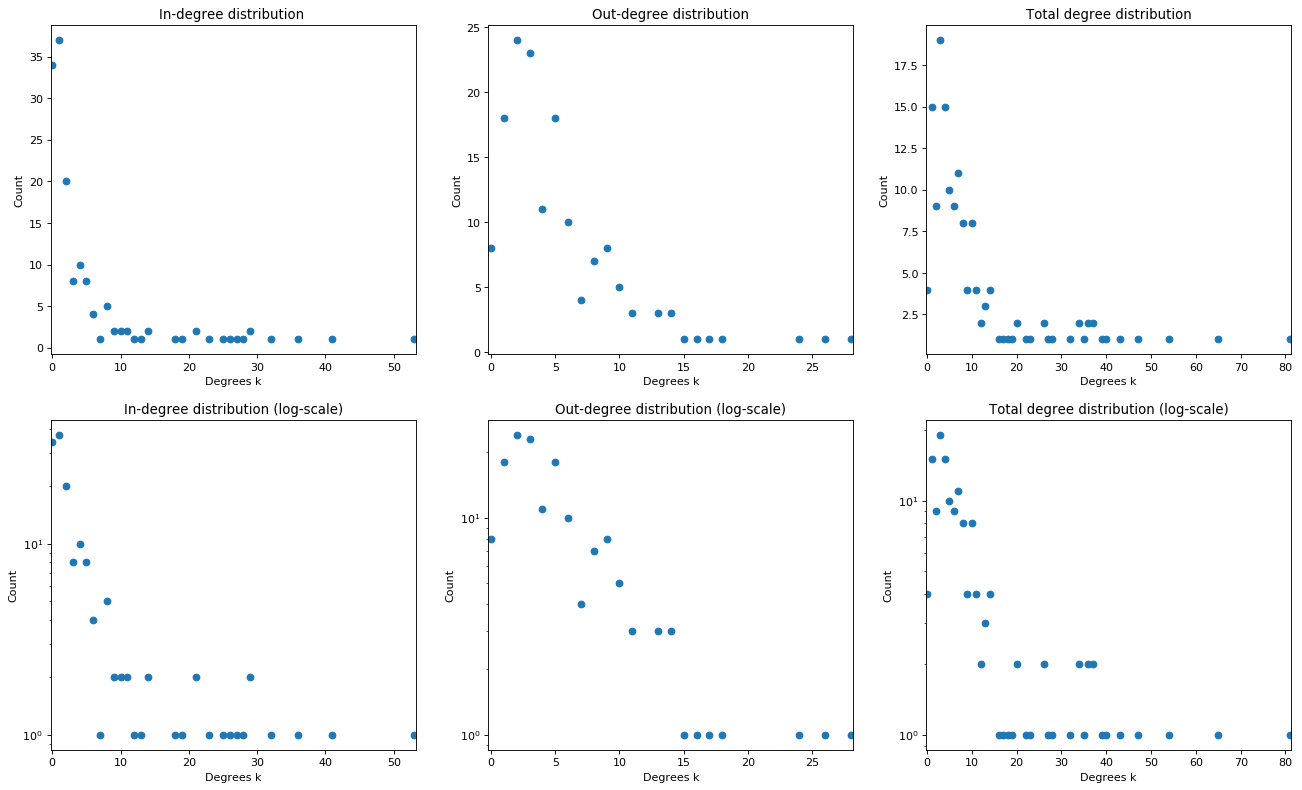

In [82]:

plt.figure(num = None, figsize = (20,12), dpi = 80,facecolor = 'w',edgecolor='k')
plt.subplot(2,3,1)
plt.plot(IN_deg_dist["bin_edge"],IN_deg_dist["val_counts"],'o')
plt.xlim(min(IN_deg_dist["bin_edge"])-0.2, max(IN_deg_dist["bin_edge"])+0.2)
plt.title('In-degree distribution ')
plt.xlabel('Degrees k')
plt.ylabel('Count')

plt.subplot(2,3,2)
plt.plot(OUT_deg_dist["bin_edge"],OUT_deg_dist["val_counts"],'o')
plt.xlim(min(OUT_deg_dist["bin_edge"])-0.2, max(OUT_deg_dist["bin_edge"])+0.2)
plt.title('Out-degree distribution')
plt.xlabel('Degrees k')
plt.ylabel('Count')

plt.subplot(2,3,4)
plt.yscale('log')
plt.plot(IN_deg_dist["bin_edge"],IN_deg_dist["val_counts"],'o')
plt.xlim(min(IN_deg_dist["bin_edge"])-0.2, max(IN_deg_dist["bin_edge"])+0.2)
plt.title('In-degree distribution (log-scale)')
plt.xlabel('Degrees k')
plt.ylabel('Count')

plt.subplot(2,3,5)
plt.yscale('log')
plt.plot(OUT_deg_dist["bin_edge"],OUT_deg_dist["val_counts"],'o')
plt.xlim(min(OUT_deg_dist["bin_edge"])-0.2, max(OUT_deg_dist["bin_edge"])+0.2)
plt.title('Out-degree distribution (log-scale)')
plt.xlabel('Degrees k')
plt.ylabel('Count')

plt.subplot(2,3,3)
plt.plot(v["bin_edge"],v["val_counts"],'o')
plt.xlim(min(v["bin_edge"])-0.2, max(v["bin_edge"])+0.2)
plt.title('Total degree distribution')
plt.xlabel('Degrees k')
plt.ylabel('Count')

plt.subplot(2,3,6)
plt.yscale('log')
plt.plot(v["bin_edge"],v["val_counts"],'o')
plt.xlim(min(v["bin_edge"])-0.2, max(v["bin_edge"])+0.2)
plt.title('Total degree distribution (log-scale)')
plt.xlabel('Degrees k')
plt.ylabel('Count')

plt.show()

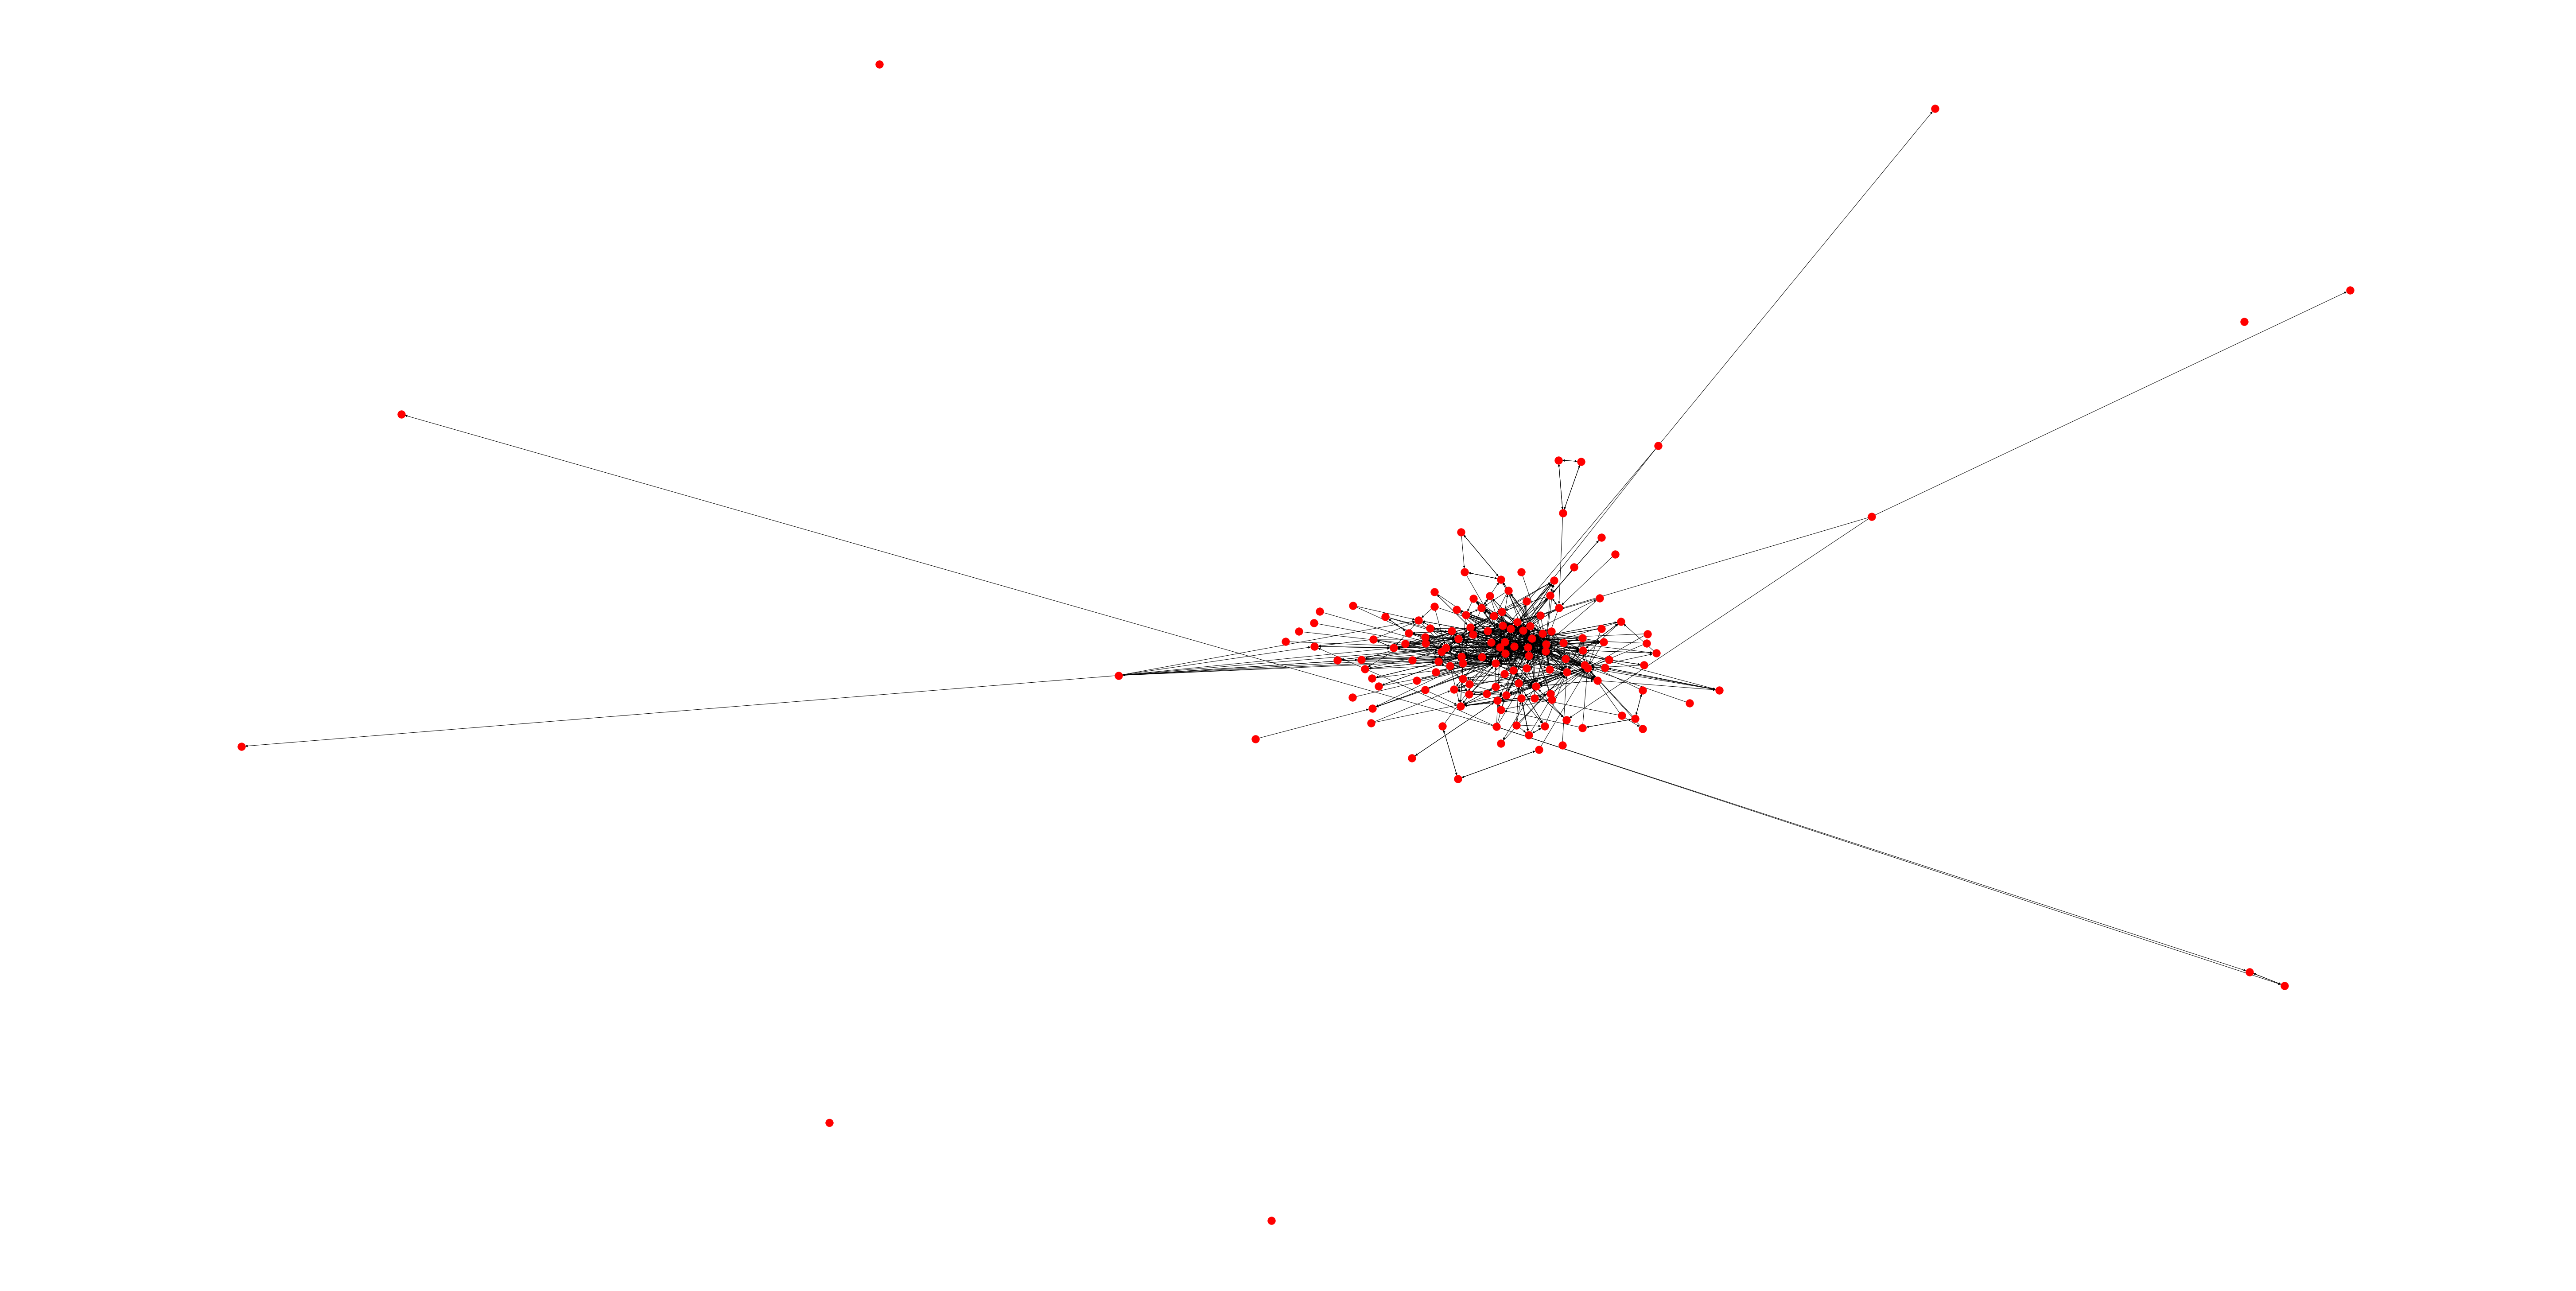

In [71]:
#Create an undirected graph to create a Giant Connected Component
G_undir = nx.Graph()
list_of_nodes = relation_lotr.keys()
G_undir.add_nodes_from(list_of_nodes)
list_of_edges = create_edges(relation_lotr)
G_undir.add_edges_from(list_of_edges)
plt.figure(1,figsize=(80,40))
nx.draw(G)
plt.draw()

In [72]:
# Extract the GCC
gcc = sorted(list(nx.connected_component_subgraphs(G_undir)), key=lambda x: len(x.nodes()))
print("There are {} giant components in the network".format(len(gcc)))

gcc_max = gcc[-1]
print("The number of nodes in the Giant Connected Component, GCC is {}".format(len(gcc_max.nodes())))

There are 5 giant components in the network
The number of nodes in the Giant Connected Component, GCC is 148
